# Graph Learning Tasks - Missing link prediction

Link prediction, also known as graph completion, is a common problem when dealing with graphs. More precisely, from a partially observed graph—a graph where for a certain pair of nodes it is not possible to exactly know if there is (or there is not) an edge between them—we want to predict whether or not edges exist for the unknown status node pairs, as seen in the following figure:

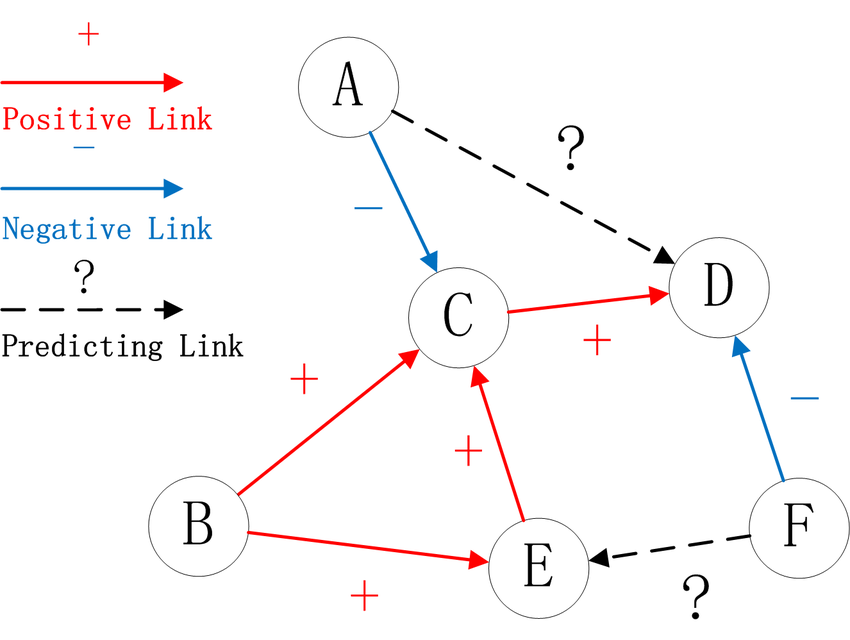

The link prediction problem is widely used in different domains, such as a recommender system in order to propose friendships in social networks or items to purchase on e-commerce websites. It is also used in criminal network investigations in order to find hidden connections between criminal clusters, as well as in bioinformatics for the analysis of protein-protein interactions.

In [ ]:
!pip install -q stellargraph
!pip install -q node2vec

In [ ]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
import matplotlib.pyplot as plt
from sklearn import metrics
from stellargraph.data import EdgeSplitter
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def draw_graph(G, node_names={}, node_size=500):
    pos_nodes = nx.spring_layout(G)
    nx.draw(G, pos_nodes, with_labels=True, node_size=node_size, edge_color='gray', arrowsize=30)
    
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
    nx.draw_networkx_labels(G, pos_attrs, font_family='serif', font_size=20)
    
    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.show()

## Similarity-based methods

The main idea is to estimate a similarity function between each couple of nodes in a graph. If, according to the function, the nodes look similar, they will have a high probability of being connected by an edge. We will divide these algorithms into two sub-families: index-based and community-based methods. The former contains all the methods through a simple calculation of an index based on the neighbors of a given couple of nodes. The latter contains more sophisticated algorithms, whereby the index is computed using information about the community to which a given couple of nodes belong.

In [ ]:
edges = [[1,3],[2,3],[2,4],[4,5],[5,6],[5,7]]
G = nx.from_edgelist(edges)
draw_graph(G)

In [ ]:
# Resource allocation index - index-based method
preds = nx.resource_allocation_index(G,[(1,2),(2,7),(4,6)])
print(list(preds))

In [ ]:
# Jaccard coefficient - another index-based method
preds = nx.jaccard_coefficient(G,[(1,2),(2,7),(4,6)])
print(list(preds))

In [ ]:
G.nodes[1]["community"] = 0
G.nodes[2]["community"] = 0
G.nodes[3]["community"] = 0

G.nodes[4]["community"] = 1
G.nodes[5]["community"] = 1
G.nodes[6]["community"] = 1
G.nodes[7]["community"] = 1

In [ ]:
# Community common neighbor - community-based method
preds = nx.cn_soundarajan_hopcroft(G,[(1,2),(2,7),(4,6)])
print(list(preds))

In [ ]:
# # Community resource allocation - another community-based method
preds = nx.ra_index_soundarajan_hopcroft(G,[(1,2),(2,7),(4,6)])
print(list(preds))

## Embedding-based method

In [ ]:
!wget https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
!tar -xvf cora.tgz

In [ ]:
edgelist = pd.read_csv("./cora/cora.cites", sep='\t', header=None, names=["target", "source"])
G = nx.from_pandas_edgelist(edgelist)
draw_graph(G)

In [ ]:
edgeSplitter = EdgeSplitter(G)
graph_test, samples_test, labels_test = edgeSplitter.train_test_split(
    p=0.1, method="global"
)

In [ ]:
edgeSplitter = EdgeSplitter(graph_test, G)
graph_train, samples_train, labels_train = edgeSplitter.train_test_split(
    p=0.1, method="global"
)

In [ ]:
node2vec = Node2Vec(graph_train)
model = node2vec.fit()
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
train_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_train]

In [ ]:
test_embeddings = [edges_embs[str(x[0]),str(x[1])] for x in samples_test]

In [ ]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(train_embeddings, labels_train);

In [ ]:
y_pred = rf.predict(test_embeddings)

print('Precision:', metrics.precision_score(labels_test, y_pred))
print('Recall:', metrics.recall_score(labels_test, y_pred))
print('F1-Score:', metrics.f1_score(labels_test, y_pred))